In [1]:
# 구글 드라이브 입력
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


설치 해야하는 것들 및 함수들

In [2]:
# pip install 요소들 정리
# annoy는 반드시 visual studio build tools 설치
! pip install -q annoy
! pip install -q FRUFS
! pip install -q pacmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 45.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
# import할 요소들 정리
import copy
import pandas as pd
import numpy as np
import warnings
import pacmap

from FRUFS import FRUFS
from lightgbm import LGBMRegressor

from sklearn.ensemble import IsolationForest

from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

import matplotlib.pyplot as plt

import os

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

from scipy.stats import ranksums

# 파일 위치 고정
os.chdir("/content/drive/MyDrive/credit_fraud/open")

# Train dataset
train_df = pd.read_csv('train.csv')
train_df = train_df.iloc[:,1:]

# Validation dataset
val_df = pd.read_csv('val.csv')
ori_val_df = val_df.iloc[:,1:]
val_class = val_df.iloc[:,31]
val_df = val_df.iloc[:,1:31]

# Test dataset
test_df = pd.read_csv('test.csv')
test_df = test_df.iloc[:,1:]

warnings.filterwarnings(action='ignore')

In [4]:
# IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
def get_pred_label(model_pred):
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

# IsolationForest 예측만 하는 함수
def iso_for_model_prediction(the_contamination, trtrtr):
    # train dataset으로 isolationforest 모델 학습
    model_only_train = IsolationForest(n_estimators=1000, contamination=the_contamination, verbose=0)
    model_only_train.fit(trtrtr)

    # train dataset의 isolationforest 모델로 예측
    train_pred = model_only_train.predict(trtrtr)
    train_pred = get_pred_label(train_pred)

    return train_pred

# Pacmac + IsolationForest 예측과 비교할 수 있는 함수
def pac_iso_for_model_comparing(the_contamination, trtrtr, low_dim, compare_class):
    # train dataset으로 isolationforest 모델 학습
    dlatl_embedding = pacmap.PaCMAP(n_components=low_dim, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, num_iters = 1000, verbose = True)
    pac_mac_train = dlatl_embedding.fit_transform(np.array(trtrtr), init="pca")

    model_train_compare = IsolationForest(n_estimators=1000, contamination=the_contamination, verbose=0)
    model_train_compare.fit(pac_mac_train)

    # train dataset의 isolationforest 모델로 예측
    train_pred = model_train_compare.predict(pac_mac_train)
    train_pred = get_pred_label(train_pred)

    # train dataset의 예측치와 compare data의 수치 비교
    train_score = f1_score(compare_class, train_pred, average='macro')

    print(f'Compared Macro F1 Score : [{train_score}]')
    print(classification_report(compare_class, train_score))

# IQR Method에서 경계값을 나타낸 함수
def iqr_outlier(ddff):
    q1 = ddff.quantile(0.25)
    q3 = ddff.quantile(0.75)

    iqr = q3 - q1

    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    return pd.concat([lower_bound, upper_bound], axis= 1).T

Validation dataset의 통계정보를 이용한 1차로 변수 선택합니다. 테스트 데이터 중 랜덤 샘플된 것이므로 Validation dataset의 통계정보로 충분히 정보를 얻을 수 있습니다.아래의 기준은 outlier의 중위값이 IQR method의 범위 내에 있는지 확인합니다. 저는 outlier의 중위값이 적어도 IQR method의 범위 밖에 있어야 outlier 판단하기 쉽다고 생각하였습니다.

In [5]:
## 기본적인 변수 선택(1)
def first_variation_selection(dfdfdf):
    # Validation dataset의 outlier들의 중앙값이 Validation dataset의 IQR Method에서 경계값 사이에 있으면 이상치를 판단하지 못하는 변수라고 정했다.
    # class 열도 있으므로 1개 제외
    how_many_var = (len(dfdfdf.columns) - 1)
    new_var = []

    for what_val in range(how_many_var):
        if (iqr_outlier(dfdfdf).iloc[0,what_val] < dfdfdf.iloc[np.where(dfdfdf['Class'] == 1)].quantile(0.5)[what_val] < iqr_outlier(dfdfdf).iloc[1,what_val]):
            continue
        else:
            new_var.append(what_val)

    return new_var

superior_var1 = first_variation_selection(ori_val_df)
print(superior_var1)

[1, 2, 3, 6, 8, 9, 10, 11, 13, 15, 16, 17]


이번엔 2차 변수 선택입니다. 두 가지 변수 방법을 사용하여 결과물을 합집합화 하였습니다. 첫번째는 Wilcoxon rank-sum test를 이용해 Validation dataset의 outlier들의 중앙값과 Validation dataset의 inlier들의 중앙값의 차이를 검정해보고 p-value가 가장 낮은 5개 변수를 뽑았습니다. 두번째는 FRUFS의 LGBMRegressor을 이용하여 변수 중요도를 판단하였고 중요도가 가장 높은 5개 변수를 뽑았습니다.

In [6]:
## 기본적인 변수 선택(2)
# 2차 변수 선택
def second_variation_selection(dfdfdf, trtrtr, nnn_var):
    ranksum_pval = []
    for what_val in nnn_var:
        ranksum_pval.append(ranksums(dfdfdf.iloc[np.where(dfdfdf['Class'] == 1)].iloc[:,what_val], dfdfdf.iloc[np.where(dfdfdf['Class'] == 0)].iloc[:,what_val]).pvalue)

    Wilcoxon_rank_sum_pval_var = list(pd.DataFrame({'pval':ranksum_pval, 'col':dfdfdf.columns[nnn_var]}).sort_values(by=['pval']).iloc[range(5),1])

    print(Wilcoxon_rank_sum_pval_var)

    # FRUFS를 이용하여 변수 선택
    # core가 많으면 n_jobs 조정을 하면 됨.
    model_frufs = FRUFS(model_r=LGBMRegressor(random_state=28), k=5, n_jobs=-1, verbose=1, random_state=28)
    df_train_pruned = model_frufs.fit_transform(trtrtr.iloc[:,nnn_var])
    FRUFS_LGBMRegressor_var = list(df_train_pruned.columns)

    #plt.figure(figsize=(5, 6), dpi=100)
    #model_frufs.feature_importance()
    print(FRUFS_LGBMRegressor_var)

    # 종합
    all_var_in_td = list(trtrtr.columns)
    new_var_set = list(set(Wilcoxon_rank_sum_pval_var + FRUFS_LGBMRegressor_var))
    new_var_list = []

    for nvs in new_var_set:
        new_var_list.append(all_var_in_td.index(nvs))

    new_var_list.sort()
    return new_var_list

superior_var2 = second_variation_selection(ori_val_df, train_df, superior_var1)
print(superior_var2)

['V10', 'V14', 'V11', 'V4', 'V12']


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


['V10', 'V4', 'V14', 'V17', 'V16']
[3, 9, 10, 11, 13, 15, 16]


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   18.5s finished


In [7]:
## 기본적인 변수 선택(3)
# 선택한 변수 제외 나머지 변수 모임
inferior_var2 = [x for x in range(30) if x not in superior_var2]
print(inferior_var2)

[0, 1, 2, 4, 5, 6, 7, 8, 12, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


Baseline에 보시면 아시겠지만 validation set의 사기 거래 비율을 탐색하였는데 저는 이보다 조금 높은 수치를 사용하였습니다.

In [8]:
## validation set의 사기 거래 비율 탐색
ori_val_normal, ori_val_fraud = ori_val_df['Class'].value_counts()
ori_val_contamination = ori_val_fraud / ori_val_normal
print(f'Validation contamination:[{ori_val_contamination}]')
# 이대로 하지 않고 조정을 함

Validation contamination:[0.0010551491277433877]


본격적으로 pacmap과 isolation forest를 이용하여 예측하고자 합니다. pacmap은 차원축소를 하는 과정에 있어 랜덤하게 이동합니다. isolation forest도 랜덤하게 변수를 선택하기 때문에 결과가 불분명합니다. 따라서 저는 hhmm번 진행하고 voting을 통해 결과를 도출하였습니다.

In [9]:
## pacmap과 isolation forest 1차 이용(1)
# pacmap과 isolation forest를 이용한 1차 예측
hhmm = 3
what_val = superior_var2
for num in range(hhmm):
    embedding_1 = pacmap.PaCMAP(n_components=len(what_val), n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, num_iters = 1000, verbose = True)
    pacmac_train_1 = embedding_1.fit_transform(np.array(train_df.iloc[:,what_val]), init="pca")
    pacmac_val_1 = embedding_1.transform(np.array(val_df.iloc[:,what_val]), basis=np.array(train_df.iloc[:,what_val]))
    pacmac_test_1 = embedding_1.transform(np.array(test_df.iloc[:,what_val]), basis=np.array(train_df.iloc[:,what_val]))

    pac_model_1 = IsolationForest(n_estimators=1000, contamination=0.00121, verbose=0)
    pac_model_1.fit(pacmac_train_1[:,[1,2,3]])

    if num == 0:
        train_pred_set_1 = pac_model_1.predict(pacmac_train_1[:,[1,2,3]]) # model prediction
        train_pred_set_1 = get_pred_label(train_pred_set_1)

        val_pred_set_1 = pac_model_1.predict(pacmac_val_1[:,[1,2,3]]) # model prediction
        val_pred_set_1 = get_pred_label(val_pred_set_1)

        test_pred_set_1 = pac_model_1.predict(pacmac_test_1[:,[1,2,3]]) # model prediction
        test_pred_set_1 = get_pred_label(test_pred_set_1)
    else:
        train_pred_1 = pac_model_1.predict(pacmac_train_1[:,[1,2,3]]) # model prediction
        train_pred_1 = get_pred_label(train_pred_1)
        train_pred_set_1 = train_pred_set_1 + train_pred_1

        val_pred_1 = pac_model_1.predict(pacmac_val_1[:,[1,2,3]]) # model prediction
        val_pred_1 = get_pred_label(val_pred_1)
        val_pred_set_1 = val_pred_set_1 + val_pred_1

        test_pred_1 = pac_model_1.predict(pacmac_test_1[:,[1,2,3]]) # model prediction
        test_pred_1 = get_pred_label(test_pred_1)
        test_pred_set_1 = test_pred_set_1 + test_pred_1

train_pred_set_1 = train_pred_set_1/hhmm
val_pred_set_1 = val_pred_set_1/hhmm
test_pred_set_1 = test_pred_set_1/hhmm

X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 1000), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2402228.750000
Iteration:   20, Loss: 2148430.250000
Iteration:   30, Loss: 2014828.500000
Iteration:   40, Loss: 1910673.250000
Iteration:   50, Loss: 1811313.375000
Iteration:   60, Loss: 1706051.000000
Iteration:   70, Loss: 1587825.250000
Iteration:   80, Loss: 1447655.875000
Iteration:   90, Loss: 1271257.500000
Iteration:  100, Loss: 1005253.500000
Iteration:  110, Loss: 1315374.000000
Iteration:  120, Loss: 1293025.375000
Iteration:  130, Loss: 1283507.125000
Iteration:  140, Loss: 1280425.875000
Iteration:  150, Loss: 1279791.750000
Iteration:  160, Loss: 1279881.875000
Iteration:  170, Loss: 1280064.000

X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 1000), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2403648.750000
Iteration:   20, Loss: 2148890.500000
Iteration:   30, Loss: 2014982.875000
Iteration:   40, Loss: 1910758.125000
Iteration:   50, Loss: 1811444.875000
Iteration:   60, Loss: 1706093.500000
Iteration:   70, Loss: 1587809.625000
Iteration:   80, Loss: 1447687.125000
Iteration:   90, Loss: 1271180.875000
Iteration:  100, Loss: 1005137.062500
Iteration:  110, Loss: 1315481.250000
Iteration:  120, Loss: 1293063.500000
Iteration:  130, Loss: 1283459.750000
Iteration:  140, Loss: 1280314.875000
Iteration:  150, Loss: 1279744.500000
Iteration:  160, Loss: 1279836.875000
Iteration:  170, Loss: 1279939.250

X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 1000), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2403264.750000
Iteration:   20, Loss: 2148342.500000
Iteration:   30, Loss: 2014800.750000
Iteration:   40, Loss: 1910647.125000
Iteration:   50, Loss: 1811314.250000
Iteration:   60, Loss: 1705952.250000
Iteration:   70, Loss: 1587685.125000
Iteration:   80, Loss: 1447588.125000
Iteration:   90, Loss: 1271124.750000
Iteration:  100, Loss: 1005190.500000
Iteration:  110, Loss: 1315436.875000
Iteration:  120, Loss: 1293093.250000
Iteration:  130, Loss: 1283664.500000
Iteration:  140, Loss: 1280511.250000
Iteration:  150, Loss: 1279922.500000
Iteration:  160, Loss: 1280058.125000
Iteration:  170, Loss: 1280119.000

In [10]:
## pacmap과 isolation forest 1차 이용(2)
val_score_1 = f1_score(ori_val_df['Class'], np.round(val_pred_set_1), average='macro')

print(f'Validation F1 Score : [{val_score_1}]')
print(classification_report(ori_val_df['Class'], np.round(val_pred_set_1)))
print(confusion_matrix(ori_val_df['Class'], np.round(val_pred_set_1)))

Validation F1 Score : [0.4995780293972853]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.00      0.00      0.00        30

    accuracy                           1.00     28462
   macro avg       0.50      0.50      0.50     28462
weighted avg       1.00      1.00      1.00     28462

[[28414    18]
 [   30     0]]


In [11]:
## pacmap과 isolation forest 1차 이용(3)
# 1차 저장
chujung_train_1 = pd.DataFrame({'Class':np.round(train_pred_set_1)})
chujung_val_1 = pd.DataFrame({'Class':np.round(val_pred_set_1)})
chujung_test_1 = pd.DataFrame({'Class':np.round(test_pred_set_1)})

result_train_1 = pd.concat([train_df,chujung_train_1], axis=1)
result_val_1 = pd.concat([val_df,chujung_val_1], axis=1)
result_test_1 = pd.concat([test_df,chujung_test_1], axis=1)

result_train_1.to_csv('result_train_1.csv', index=False)
result_val_1.to_csv('result_val_1.csv', index=False)
result_test_1.to_csv('result_test_1.csv', index=False)

In [12]:
## pacmap과 isolation forest 1차 이용(4)
# 1차 불러오기
train_pred_set_1 = np.array(pd.read_csv('result_train_1.csv')['Class'])
val_pred_set_1 = np.array(pd.read_csv('result_val_1.csv')['Class'])
test_pred_set_1 = np.array(pd.read_csv('result_test_1.csv')['Class'])

저는 이에 더해 변수를 좀 더 추가하면서 val score를 높일 수 있을까 생각하였습니다. 그래서 저는 설령 outlier들이 inlier안에 숨어있을지라도 inlier들이 모여있으면 isolation forest가 판단하는데 있어서 도움이 된다고 들었습니다. 이에 따라 저는 outlier들이 inlier안에 들어있지만 최대한 outlier들의 분산이 적으면서 최대한 inlier들의 분산을 넓은 변수를 찾고자 하였습니다. (i.e. (inlier들의 분산/outlier들의 분산)이 높은 것들). 역시 validation set의 통계정보를 이용하였습니다. 그 다음, outlier의 중앙값을 기준으로 inlier들을 나누어서, 각 inlier들의 중앙값이 outlier의 중앙값과 차이가 큰지(wilcoxon rank sum test), 각 inlier들의 분산이 작은지(해당 분산이 작으면 inlier와 구별할 수 있다고 생각하였습니다.)를 보았습니다. 변수를 최대한 적게 선택하고자 이번엔 해당 방법들에서 나온 변수들의 교집합을 선택하였습니다.

In [13]:
## pacmap과 isolation forest 2차 이용
inside_in_inlier= []

for what_val in range(30):
    if ori_val_df.iloc[np.where(ori_val_df['Class'] == 1)].max()[what_val] <  ori_val_df.iloc[np.where(ori_val_df['Class'] == 0)].max()[what_val]:
        if ori_val_df.iloc[np.where(ori_val_df['Class'] == 1)].min()[what_val] >  ori_val_df.iloc[np.where(ori_val_df['Class'] == 0)].min()[what_val]:
            inside_in_inlier.append(what_val)

print(inside_in_inlier)

var_chai = []
for what_val in inside_in_inlier:
    print(what_val , ori_val_df.iloc[np.where(ori_val_df['Class'] == 0)[0],what_val].var()/ori_val_df.iloc[np.where(ori_val_df['Class'] == 1)[0],what_val].var())
    var_chai.append(ori_val_df.iloc[np.where(ori_val_df['Class'] == 0)[0],what_val].var()/ori_val_df.iloc[np.where(ori_val_df['Class'] == 1)[0],what_val].var())

old_born_idx = np.argsort((-1)*np.array(var_chai))[:5]
old_born_idx = np.array(inside_in_inlier)[list(old_born_idx)]
old_born_idx = list(old_born_idx)
print(old_born_idx)

left_side_l = []
right_side_l = []
for jjkk in inside_in_inlier:
    the_one_the_one = ori_val_df.iloc[np.where(ori_val_df['Class'] == 1)[0],jjkk]
    median_the_one = the_one_the_one.median()
    the_zero_the_zero = ori_val_df.iloc[np.where(ori_val_df['Class'] == 0)[0],jjkk]
    left_zero_val_df = the_zero_the_zero.iloc[np.where(the_zero_the_zero < median_the_one)[0]]
    right_zero_val_df = the_zero_the_zero.iloc[np.where(the_zero_the_zero > median_the_one)[0]]
    left_ppp = (ranksums(left_zero_val_df, the_one_the_one).pvalue)
    right_ppp = (ranksums(right_zero_val_df, the_one_the_one).pvalue)

    left_side_l.append((left_ppp*1000)*((left_zero_val_df.var())))
    right_side_l.append((right_ppp*1000)*((right_zero_val_df.var())))

left_born_idx = np.argsort(np.array(left_side_l))[:5]
left_born_idx = np.array(inside_in_inlier)[list(left_born_idx)]
left_born_idx = list(left_born_idx)

right_born_idx = np.argsort(np.array(right_side_l))[:5]
right_born_idx = np.array(inside_in_inlier)[list(right_born_idx)]
right_born_idx = list(right_born_idx)

print(left_born_idx)
print(right_born_idx)

dhk_add_list = list(set(old_born_idx) & set(left_born_idx) & set(right_born_idx))
print(dhk_add_list)

[0, 4, 5, 12, 14, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29]
0 0.05661145915960422
4 0.042238859285244915
5 0.7704461525574517
12 0.7649192536979103
14 0.5924508408804108
18 0.20398714517248479
19 0.3715199816934372
20 0.06681438471306131
21 0.47076015284507716
22 0.5165263768776033
23 1.3711184736256397
24 0.46796859661491685
25 0.7132699705783713
26 0.03718584298750135
27 0.2518467335386648
29 0.7823436145492899
[np.int64(23), np.int64(29), np.int64(5), np.int64(12), np.int64(25)]
[np.int64(25), np.int64(21), np.int64(23), np.int64(24), np.int64(20)]
[np.int64(5), np.int64(0), np.int64(24), np.int64(23), np.int64(29)]
[np.int64(23)]


지금까지 선택한 변수들을 바탕으로 pacmap과 isolation forest를 돌려 예측합니다.

In [14]:
## pacmap과 isolation forest 3차 이용(1)
# pacmap과 isolation forest를 이용한 2차 예측
hhmm = 7
vlskffo_var = superior_var2 + dhk_add_list
what_val = vlskffo_var

for num in range(hhmm):
    embedding_3 = pacmap.PaCMAP(n_components=len(what_val), n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, num_iters = 600, verbose = True)
    pacmac_train_3 = embedding_3.fit_transform(np.array(train_df.iloc[:,what_val]), init="pca")
    pacmac_val_3 = embedding_3.transform(np.array(val_df.iloc[:,what_val]), basis=np.array(train_df.iloc[:,what_val]))
    pacmac_test_3 = embedding_3.transform(np.array(test_df.iloc[:,what_val]), basis=np.array(train_df.iloc[:,what_val]))

    pac_model_3 = IsolationForest(n_estimators=1000, contamination=0.00121, verbose=0)
    pac_model_3.fit(pacmac_train_3[:,[1,2,3]])

    if num == 0:
        train_pred_set_3 = pac_model_3.predict(pacmac_train_3[:,[1,2,3]]) # model prediction
        train_pred_set_3 = get_pred_label(train_pred_set_3)

        val_pred_set_3 = pac_model_3.predict(pacmac_val_3[:,[1,2,3]]) # model prediction
        val_pred_set_3 = get_pred_label(val_pred_set_3)

        test_pred_set_3 = pac_model_3.predict(pacmac_test_3[:,[1,2,3]]) # model prediction
        test_pred_set_3 = get_pred_label(test_pred_set_3)
    else:
        train_pred_3 = pac_model_3.predict(pacmac_train_3[:,[1,2,3]]) # model prediction
        train_pred_3 = get_pred_label(train_pred_3)
        train_pred_set_3 = train_pred_set_3 + train_pred_3

        val_pred_3 = pac_model_3.predict(pacmac_val_3[:,[1,2,3]]) # model prediction
        val_pred_3 = get_pred_label(val_pred_3)
        val_pred_set_3 = val_pred_set_3 + val_pred_3

        test_pred_3 = pac_model_3.predict(pacmac_test_3[:,[1,2,3]]) # model prediction
        test_pred_3 = get_pred_label(test_pred_3)
        test_pred_set_3 = test_pred_set_3 + test_pred_3

train_pred_set_3 = train_pred_set_3/hhmm
val_pred_set_3 = val_pred_set_3/hhmm
test_pred_set_3 = test_pred_set_3/hhmm

X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 600), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2461775.750000
Iteration:   20, Loss: 2168415.500000
Iteration:   30, Loss: 2027081.875000
Iteration:   40, Loss: 1920398.250000
Iteration:   50, Loss: 1820254.000000
Iteration:   60, Loss: 1715000.000000
Iteration:   70, Loss: 1597410.500000
Iteration:   80, Loss: 1458427.625000
Iteration:   90, Loss: 1283141.875000
Iteration:  100, Loss: 1019681.625000
Iteration:  110, Loss: 1338646.500000
Iteration:  120, Loss: 1313941.125000
Iteration:  130, Loss: 1302487.875000
Iteration:  140, Loss: 1298397.750000
Iteration:  150, Loss: 1297410.250000
Iteration:  160, Loss: 1297464.250000
Iteration:  170, Loss: 1297484.3750

X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 600), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2461952.250000
Iteration:   20, Loss: 2168526.500000
Iteration:   30, Loss: 2026842.750000
Iteration:   40, Loss: 1920142.750000
Iteration:   50, Loss: 1820105.125000
Iteration:   60, Loss: 1714767.250000
Iteration:   70, Loss: 1597166.500000
Iteration:   80, Loss: 1458292.750000
Iteration:   90, Loss: 1283121.750000
Iteration:  100, Loss: 1019751.500000
Iteration:  110, Loss: 1338871.500000
Iteration:  120, Loss: 1314055.125000
Iteration:  130, Loss: 1302610.625000
Iteration:  140, Loss: 1298560.625000
Iteration:  150, Loss: 1297673.000000
Iteration:  160, Loss: 1297658.625000
Iteration:  170, Loss: 1297670.5000

X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 600), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2461725.500000
Iteration:   20, Loss: 2168007.250000
Iteration:   30, Loss: 2026621.750000
Iteration:   40, Loss: 1920032.500000
Iteration:   50, Loss: 1819929.000000
Iteration:   60, Loss: 1714591.750000
Iteration:   70, Loss: 1596954.750000
Iteration:   80, Loss: 1458039.000000
Iteration:   90, Loss: 1282892.125000
Iteration:  100, Loss: 1019641.000000
Iteration:  110, Loss: 1338756.375000
Iteration:  120, Loss: 1314110.375000
Iteration:  130, Loss: 1302469.375000
Iteration:  140, Loss: 1298309.500000
Iteration:  150, Loss: 1297346.625000
Iteration:  160, Loss: 1297386.625000
Iteration:  170, Loss: 1297386.3750

X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 600), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2461377.500000
Iteration:   20, Loss: 2168023.250000
Iteration:   30, Loss: 2026753.500000
Iteration:   40, Loss: 1920066.500000
Iteration:   50, Loss: 1819998.750000
Iteration:   60, Loss: 1714717.875000
Iteration:   70, Loss: 1597078.000000
Iteration:   80, Loss: 1458236.125000
Iteration:   90, Loss: 1283056.375000
Iteration:  100, Loss: 1019647.250000
Iteration:  110, Loss: 1338818.875000
Iteration:  120, Loss: 1314021.250000
Iteration:  130, Loss: 1302398.750000
Iteration:  140, Loss: 1298231.375000
Iteration:  150, Loss: 1297251.750000
Iteration:  160, Loss: 1297253.750000
Iteration:  170, Loss: 1297391.8750

X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 600), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2462191.500000
Iteration:   20, Loss: 2168392.500000
Iteration:   30, Loss: 2027069.875000
Iteration:   40, Loss: 1920309.000000
Iteration:   50, Loss: 1820158.500000
Iteration:   60, Loss: 1714794.125000
Iteration:   70, Loss: 1597152.000000
Iteration:   80, Loss: 1458323.375000
Iteration:   90, Loss: 1283058.250000
Iteration:  100, Loss: 1019721.500000
Iteration:  110, Loss: 1338791.625000
Iteration:  120, Loss: 1314080.500000
Iteration:  130, Loss: 1302571.875000
Iteration:  140, Loss: 1298458.250000
Iteration:  150, Loss: 1297467.750000
Iteration:  160, Loss: 1297460.000000
Iteration:  170, Loss: 1297635.1250

X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 600), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2461204.500000
Iteration:   20, Loss: 2168521.750000
Iteration:   30, Loss: 2027370.500000
Iteration:   40, Loss: 1920610.250000
Iteration:   50, Loss: 1820498.500000
Iteration:   60, Loss: 1715169.750000
Iteration:   70, Loss: 1597420.000000
Iteration:   80, Loss: 1458530.375000
Iteration:   90, Loss: 1283298.250000
Iteration:  100, Loss: 1019936.625000
Iteration:  110, Loss: 1338842.250000
Iteration:  120, Loss: 1313979.125000
Iteration:  130, Loss: 1302462.750000
Iteration:  140, Loss: 1298311.000000
Iteration:  150, Loss: 1297430.500000
Iteration:  160, Loss: 1297399.375000
Iteration:  170, Loss: 1297412.6250

X is normalized
PaCMAP(n_neighbors=26, n_MN=13, n_FP=52, distance=euclidean, lr=1.0, n_iters=(100, 100, 600), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((2959892, 2), (1479946, 2), (5919784, 2))
Initial Loss: 3658542.0
Iteration:   10, Loss: 2460801.250000
Iteration:   20, Loss: 2168297.000000
Iteration:   30, Loss: 2026870.875000
Iteration:   40, Loss: 1920238.250000
Iteration:   50, Loss: 1820207.250000
Iteration:   60, Loss: 1714958.625000
Iteration:   70, Loss: 1597334.250000
Iteration:   80, Loss: 1458376.250000
Iteration:   90, Loss: 1283156.500000
Iteration:  100, Loss: 1019738.937500
Iteration:  110, Loss: 1338913.375000
Iteration:  120, Loss: 1314164.500000
Iteration:  130, Loss: 1302540.000000
Iteration:  140, Loss: 1298428.750000
Iteration:  150, Loss: 1297509.875000
Iteration:  160, Loss: 1297543.250000
Iteration:  170, Loss: 1297508.0000

In [15]:
## pacmap과 isolation forest 3차 이용(2)
val_score_3 = f1_score(ori_val_df['Class'], np.round(val_pred_set_3), average='macro')

print(f'Validation F1 Score : [{val_score_3}]')
print(classification_report(ori_val_df['Class'], np.round(val_pred_set_3)))
print(confusion_matrix(ori_val_df['Class'], np.round(val_pred_set_3)))

Validation F1 Score : [0.9309641419574389]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.89      0.83      0.86        30

    accuracy                           1.00     28462
   macro avg       0.95      0.92      0.93     28462
weighted avg       1.00      1.00      1.00     28462

[[28429     3]
 [    5    25]]


In [16]:
set(test_pred_set_3)

{np.float64(0.0), np.float64(0.14285714285714285), np.float64(1.0)}

In [17]:
## pacmap과 isolation forest 3차 이용(3)
# 2차 저장
chujung_train_2 = pd.DataFrame({'Class':np.round(train_pred_set_3)})
chujung_val_2 = pd.DataFrame({'Class':np.round(val_pred_set_3)})
chujung_test_2 = pd.DataFrame({'Class':np.round(test_pred_set_3)})

result_train_2 = pd.concat([train_df,chujung_train_2], axis=1)
result_val_2 = pd.concat([val_df,chujung_val_2], axis=1)
result_test_2 = pd.concat([test_df,chujung_test_2], axis=1)

result_train_2.to_csv('result_train_2.csv', index=False)
result_val_2.to_csv('result_val_2.csv', index=False)
result_test_2.to_csv('result_test_2.csv', index=False)

In [18]:
## pacmap과 isolation forest 3차 이용(4)
# 2차 불러오기 및 outlier된 dataset 모음
train_pred_set_3 = np.array(pd.read_csv('result_train_2.csv')['Class'])
val_pred_set_3 = np.array(pd.read_csv('result_val_2.csv')['Class'])
test_pred_set_3 = np.array(pd.read_csv('result_test_2.csv')['Class'])

one_train_df = train_df.iloc[np.where(np.round(train_pred_set_3) == 1)[0]]
one_val_df = ori_val_df.iloc[np.where(np.round(val_pred_set_3) == 1)[0]]
one_test_df = test_df.iloc[np.where(np.round(test_pred_set_3) == 1)[0]]

저는 이에 더해 판별된 outlier들 중에 가짜를 도출하기로 생각했습니다.
역시 저는 변수를 선택하였고 validation dataset의 통계정보를 이용하였습니다. 이번엔 다른 방식으로 판별하고자 합니다. 개인적으로 저는 isolation forest를 사용함에도 표출이 안 된것은 특정 변수하에서는 가짜 outlier들이 진짜 outlier안에 숨어있다고 생각하였습니다. 그에 따라 KernelPCA를 이용해서 안쪽에 있는 가짜 outlier을 빼내고, pacmap을 사용한 다음, pca를 통해 좌표를 바꾸고, 극단값 중 몇몇개를 뽑아서 가짜 outlier라고 생각하였습니다. 우선, Validation dataset 내 ouliter로 판별된 것 중에서 실제 outlier들의 중위값과 가짜 outlier들의 중위값 검정 비교하였고, Validation dataset 내 ouliter로 판별된 것 중에서 실제 outlier들의 분산와 가짜 outlier 비율 체크해서 변수들을 확인하였습니다.

In [19]:
## outlier 중 가짜 판별(1)
# 변수 선택

rrr_df = []
for what_val in range(30):
    rrr_df.append(ranksums(one_val_df.iloc[np.where(one_val_df['Class'] == 1)[0],what_val],one_val_df.iloc[np.where(one_val_df['Class'] == 0)[0],what_val]).pvalue)

rrr_idx = np.where(np.array(rrr_df) > 0.05)[0]

qqq_df = []
for what_val in rrr_idx:
    qqq_df.append(one_val_df.iloc[np.where(one_val_df['Class'] == 0)[0],what_val].var()/one_val_df.iloc[np.where(one_val_df['Class'] == 1)[0],what_val].var())

new_born_idx = np.argsort(qqq_df)[:5]

In [20]:
print(new_born_idx)

[20 23 14  3 18]


다음으로 가짜 판별하는데 있어서 위에서 이야기한 그대로 바탕으로 진행하였습니다. 가짜 outlier인지 아닌지 판별하는데 있어서 Validation set의 통계정보와 wilcoxon rank sum test를 이용하였습니다.

In [21]:
## outlier 중 가짜 판별(2)
# 판별
transformer = KernelPCA(n_components=5, kernel='rbf')
hhhhh = new_born_idx
can_sepearate = np.argsort(rrr_df)[0]

X_transformed = transformer.fit_transform(one_train_df.iloc[:,hhhhh])
X1_transformed = transformer.transform(one_val_df.iloc[:,hhhhh])
X2_transformed = transformer.transform(one_test_df.iloc[:,hhhhh])

# kernel pca 후 1에서 0 찾기 by pacmap 그후 판별
hhmm = 201
skip_count = 0

contamin = 0.0725
making_set = 0

for num in range(hhmm):
    embedding1010 = pacmap.PaCMAP(n_components=3, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, num_iters = 1000, verbose = False)
    pacmac_train1010 = embedding1010.fit_transform(X_transformed, init="pca")
    pacmac_val1010 = embedding1010.transform(X1_transformed, basis=X_transformed)
    pacmac_test1010 = embedding1010.transform(X2_transformed, basis=X_transformed)

    # 그냥 pca
    pcawow = PCA(n_components = 3) # 주성분을 몇개로 할지 결정
    pca_train_wow = pcawow.fit_transform(pacmac_train1010)
    pca_train_wow = pd.DataFrame(data=pca_train_wow)

    pca_val_wow = pcawow.transform(pacmac_val1010)
    pca_val_wow = pd.DataFrame(data=pca_val_wow)

    pca_test_wow = pcawow.transform(pacmac_test1010)
    pca_test_wow = pd.DataFrame(data=pca_test_wow)

    rlwns = int(contamin*len(pca_train_wow))
    thtn = contamin*len(pca_train_wow) - rlwns

    if making_set == 0:
        max_part_zero = 0
        max_part_one = 0
        max_what = 100

        # PC 축을 설정하고 좌 또는 우 극단값을 찾고 해당하는 중위값이 실제 outlier들의 중위값인지 체크
        for jrj in range(6):
            val_pred_set_1010 = pd.DataFrame({'Class':np.repeat(1,len(pca_val_wow))})

            if jrj % 2 == 0:
                rlwns_val = pca_train_wow.iloc[:,(jrj//2)].nlargest(rlwns).iloc[(rlwns-1)]
                rlwns_val_Qkd = pca_train_wow.iloc[:,(jrj//2)].nlargest((rlwns+1)).iloc[(rlwns)]

                val_pred_set_1010.iloc[np.where(pca_val_wow.iloc[:,(jrj//2)] >= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn) ))] = 0
            else:
                rlwns_val = pca_train_wow.iloc[:,(jrj//2)].nsmallest(rlwns).iloc[(rlwns-1)]
                rlwns_val_Qkd = pca_train_wow.iloc[:,(jrj//2)].nsmallest((rlwns+1)).iloc[(rlwns)]

                val_pred_set_1010.iloc[np.where(pca_val_wow.iloc[:,(jrj//2)] <= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0

            ranksum_pval_ed_one = ranksums(one_val_df.iloc[np.where(one_val_df['Class'] == 1)[0],can_sepearate],one_val_df.iloc[np.where(val_pred_set_1010['Class'] == 1)[0],can_sepearate]).pvalue
            ranksum_pval_ed_zero = ranksums(one_val_df.iloc[np.where(one_val_df['Class'] == 0)[0],can_sepearate],one_val_df.iloc[np.where(val_pred_set_1010['Class'] == 0)[0],can_sepearate]).pvalue

            if np.isnan(ranksum_pval_ed_zero):
                continue

            if max_part_zero <= ranksum_pval_ed_zero:
                max_part_zero = ranksum_pval_ed_zero
            if max_part_one <= ranksum_pval_ed_one:
                max_part_one = ranksum_pval_ed_one

            if max_part_zero >= 0.5:
                if max_part_one >= 0.5:
                    max_what = jrj
                    break

        if max_what == 100:
            skip_count += 1
            continue
        making_set += 10

        # 체크 후 해당하는 축으로 가짜 outlier 판별
        val_pred_set_1010 = pd.DataFrame({'Class':np.repeat(1,len(pca_val_wow))})

        if max_what % 2 == 0:
            rlwns_val = pca_train_wow.iloc[:,(max_what//2)].nlargest(rlwns).iloc[(rlwns-1)]
            rlwns_val_Qkd = pca_train_wow.iloc[:,(max_what//2)].nlargest((rlwns+1)).iloc[(rlwns)]

            val_pred_set_1010.iloc[np.where(pca_val_wow.iloc[:,(max_what//2)] >= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0

        else:
            rlwns_val = pca_train_wow.iloc[:,(max_what//2)].nsmallest(rlwns).iloc[(rlwns-1)]
            rlwns_val_Qkd = pca_train_wow.iloc[:,(max_what//2)].nsmallest((rlwns+1)).iloc[(rlwns)]

            val_pred_set_1010.iloc[np.where(pca_val_wow.iloc[:,(max_what//2)] <= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0

        train_pred_set_1010 = pd.DataFrame({'Class':np.repeat(1,len(pca_train_wow))})

        if max_what % 2 == 0:
            train_pred_set_1010.iloc[np.where(pca_train_wow.iloc[:,(max_what//2)] >= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0
        else:
            train_pred_set_1010.iloc[np.where(pca_train_wow.iloc[:,(max_what//2)] <= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0

        test_pred_set_1010 = pd.DataFrame({'Class':np.repeat(1,len(pca_test_wow))})

        if max_what % 2 == 0:
            test_pred_set_1010.iloc[np.where(pca_test_wow.iloc[:,(max_what//2)] >= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0
        else:
            test_pred_set_1010.iloc[np.where(pca_test_wow.iloc[:,(max_what//2)] <= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0

    else:
        max_part_zero = 0
        max_part_one = 0
        max_what = 100

        # PC 축을 설정하고 좌 또는 우 극단값을 찾고 해당하는 중위값이 실제 outlier들의 중위값인지 체크
        for jrj in range(6):
            val_pred_1010 = pd.DataFrame({'Class':np.repeat(1,len(pca_val_wow))})

            if jrj % 2 == 0:
                rlwns_val = pca_train_wow.iloc[:,(jrj//2)].nlargest(rlwns).iloc[(rlwns-1)]
                rlwns_val_Qkd = pca_train_wow.iloc[:,(jrj//2)].nlargest((rlwns+1)).iloc[(rlwns)]

                val_pred_1010.iloc[np.where(pca_val_wow.iloc[:,(jrj//2)] >= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn) ))] = 0
            else:
                rlwns_val = pca_train_wow.iloc[:,(jrj//2)].nsmallest(rlwns).iloc[(rlwns-1)]
                rlwns_val_Qkd = pca_train_wow.iloc[:,(jrj//2)].nsmallest((rlwns+1)).iloc[(rlwns)]

                val_pred_1010.iloc[np.where(pca_val_wow.iloc[:,(jrj//2)] <= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0

            ranksum_pval_ed_one = ranksums(one_val_df.iloc[np.where(one_val_df['Class'] == 1)[0],can_sepearate],one_val_df.iloc[np.where(val_pred_1010['Class'] == 1)[0],can_sepearate]).pvalue
            ranksum_pval_ed_zero = ranksums(one_val_df.iloc[np.where(one_val_df['Class'] == 0)[0],can_sepearate],one_val_df.iloc[np.where(val_pred_1010['Class'] == 0)[0],can_sepearate]).pvalue

            if np.isnan(ranksum_pval_ed_zero):
                continue

            if max_part_zero <= ranksum_pval_ed_zero:
                max_part_zero = ranksum_pval_ed_zero
            if max_part_one <= ranksum_pval_ed_one:
                max_part_one = ranksum_pval_ed_one

            if max_part_zero >= 0.5:
                if max_part_one >= 0.5:
                    max_what = jrj
                    break

        if max_what == 100:
            skip_count += 1
            continue

        # 체크 후 해당하는 축으로 가짜 outlier 판별
        val_pred_1010 = pd.DataFrame({'Class':np.repeat(1,len(pca_val_wow))})

        if max_what % 2 == 0:
            rlwns_val = pca_train_wow.iloc[:,(max_what//2)].nlargest(rlwns).iloc[(rlwns-1)]
            rlwns_val_Qkd = pca_train_wow.iloc[:,(max_what//2)].nlargest((rlwns+1)).iloc[(rlwns)]

            val_pred_1010.iloc[np.where(pca_val_wow.iloc[:,(max_what//2)] >= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0
        else:
            rlwns_val = pca_train_wow.iloc[:,(max_what//2)].nsmallest(rlwns).iloc[(rlwns-1)]
            rlwns_val_Qkd = pca_train_wow.iloc[:,(max_what//2)].nsmallest((rlwns+1)).iloc[(rlwns)]

            val_pred_1010.iloc[np.where(pca_val_wow.iloc[:,(max_what//2)] <= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0

        ranksum_pval_ed_one = ranksums(one_val_df.iloc[np.where(one_val_df['Class'] == 1)[0],can_sepearate],one_val_df.iloc[np.where(val_pred_1010['Class'] == 1)[0],can_sepearate]).pvalue
        ranksum_pval_ed_zero = ranksums(one_val_df.iloc[np.where(one_val_df['Class'] == 0)[0],can_sepearate],one_val_df.iloc[np.where(val_pred_1010['Class'] == 0)[0],can_sepearate]).pvalue

        val_pred_set_1010 = val_pred_set_1010 + val_pred_1010

        train_pred_1010 = pd.DataFrame({'Class':np.repeat(1,len(pca_train_wow))})

        if max_what % 2 == 0:
            train_pred_1010.iloc[np.where(pca_train_wow.iloc[:,(max_what//2)] >= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0
        else:
            train_pred_1010.iloc[np.where(pca_train_wow.iloc[:,(max_what//2)] <= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0

        train_pred_set_1010 = train_pred_set_1010 + train_pred_1010

        test_pred_1010 = pd.DataFrame({'Class':np.repeat(1,len(pca_test_wow))})

        if max_what % 2 == 0:
            test_pred_1010.iloc[np.where(pca_test_wow.iloc[:,(max_what//2)] >= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0
        else:
            test_pred_1010.iloc[np.where(pca_test_wow.iloc[:,(max_what//2)] <= (rlwns_val_Qkd*thtn  + rlwns_val*(1-thtn)))] = 0

        test_pred_set_1010 = test_pred_set_1010 + test_pred_1010

train_pred_set_1010 = train_pred_set_1010/(hhmm- skip_count)
val_pred_set_1010 = val_pred_set_1010/(hhmm-skip_count)
test_pred_set_1010 = test_pred_set_1010/(hhmm-skip_count)

In [22]:
## 최종 확인
# voting해서 50% 이상 1이면 1로, 반대면 0으로
final_one_train_df = one_train_df.iloc[np.where(np.round(train_pred_set_1010['Class']) == 1)[0]]
final_one_val_df = one_val_df.iloc[np.where(np.round(val_pred_set_1010['Class']) == 1)[0]]
final_one_test_df = one_test_df.iloc[np.where(np.round(test_pred_set_1010['Class']) == 1)[0]]

# validation score 확인
chujung_train2 = pd.DataFrame({'Class':np.repeat(0,len(train_df))})
chujung_val2 = pd.DataFrame({'pre_Class':np.repeat(0,len(val_df))})
chujung_test2 = pd.DataFrame({'Class':np.repeat(0,len(test_df))})

chujung_train2.iloc[final_one_train_df.index,0] = 1
chujung_val2.iloc[final_one_val_df.index,0] = 1
chujung_test2.iloc[final_one_test_df.index,0] = 1

sec_result_train = pd.concat([train_df,chujung_train2], axis=1)
sec_result_val = pd.concat([val_df,chujung_val2], axis=1)
sec_result_test = pd.concat([test_df,chujung_test2], axis=1)

print('F1-score',f1_score(sec_result_val['pre_Class'], val_class, average='macro'))
print(confusion_matrix(sec_result_val['pre_Class'], val_class))
print(classification_report(sec_result_val['pre_Class'], val_class))

# 저장
submit = pd.read_csv('sample_submission.csv')
submit['Class'] = 0

submit.iloc[final_one_test_df.index,1] = 1
submit.iloc[final_one_test_df.index,1]

submit.to_csv('result_submit.csv', index=False)

F1-score 0.954501493863888
[[28432     5]
 [    0    25]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28437
           1       0.83      1.00      0.91        25

    accuracy                           1.00     28462
   macro avg       0.92      1.00      0.95     28462
weighted avg       1.00      1.00      1.00     28462



In [23]:
# ============================================================
# [추가 셀 0] Imports & 기본 설정 (노트북 맨 아래에 추가)
# ============================================================
import os
import re
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats import ranksums, ks_2samp
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.decomposition import PCA

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

def _exists(name: str) -> bool:
    return name in globals()

def _g(name: str, default=None):
    return globals().get(name, default)

def _try_float(x):
    try:
        return float(x)
    except Exception:
        return None

def _ensure_1d(a):
    if a is None:
        return None
    a = np.asarray(a)
    return a.reshape(-1)

def _ensure_2d(X):
    if X is None:
        return None
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    return X

def _feature_cols(df: pd.DataFrame):
    # train/val/test: ID + V1..V30 이 일반적
    return [c for c in df.columns if c.startswith("V")]

def _safe_sample_idx(n, max_n=8000, seed=42):
    if n <= max_n:
        return np.arange(n)
    rng = np.random.default_rng(seed)
    return rng.choice(n, size=max_n, replace=False)

def _scatter2d(X2, y=None, title="", max_points=12000, alpha=0.35):
    X2 = _ensure_2d(X2)
    if X2.shape[1] < 2:
        print(f"[WARN] {title}: 2D scatter requires >=2 dims, got {X2.shape}")
        return
    idx = _safe_sample_idx(len(X2), max_points)
    xs, ys = X2[idx, 0], X2[idx, 1]
    plt.figure(figsize=(7,6))
    if y is None:
        plt.scatter(xs, ys, s=6, alpha=alpha)
    else:
        y = _ensure_1d(y)
        yy = y[idx]
        # class 0/1 분리 표시(색 지정은 matplotlib 기본 cycle 사용)
        plt.scatter(xs[yy==0], ys[yy==0], s=6, alpha=alpha, label="0")
        plt.scatter(xs[yy==1], ys[yy==1], s=6, alpha=alpha, label="1")
        plt.legend()
    plt.title(title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.show()

def _hist1d(a, title="", bins=60):
    a = _ensure_1d(a)
    plt.figure(figsize=(10,4))
    plt.hist(a, bins=bins)
    plt.title(title)
    plt.show()

def _print_header(msg):
    print("\n" + "="*80)
    print(msg)
    print("="*80)


In [24]:
# ============================================================
# [추가 셀 1] 현재 노트북 전역변수에서 주요 객체 자동 탐색
#  - train/val/test df
#  - (가능하면) ori_val_df
# ============================================================
_print_header("1) 데이터프레임/핵심 변수 자동 탐색")

train_df = _g("train_df")
val_df   = _g("val_df")
test_df  = _g("test_df")

ori_val_df = _g("ori_val_df", val_df)  # 1등 코드에서 ori_val_df를 쓰는 경우가 많음:contentReference[oaicite:10]{index=10}

for name, df in [("train_df", train_df), ("val_df", val_df), ("test_df", test_df), ("ori_val_df", ori_val_df)]:
    if df is None:
        print(f"- {name}: NOT FOUND")
    else:
        print(f"- {name}: shape={df.shape}, cols={len(df.columns)}")
        print(df.head(2))

if train_df is None or val_df is None or test_df is None:
    print("\n[중요] 위 3개(train_df/val_df/test_df)가 없으면 아래 진단이 제대로 안 돼요.")
    print("       1등 코드 로딩 셀(데이터 read_csv)까지 먼저 실행하고 다시 실행하세요.")



1) 데이터프레임/핵심 변수 자동 탐색
- train_df: shape=(113842, 30), cols=30
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.247676 -1.514654  0.207643  ...  0.247998  0.771679  0.909412 -0.689281   
1  0.377436 -1.387024 -0.054952  ... -0.108300  0.005274 -0.190321 -1.175575   

        V25       V26       V27       V28       V29       V30  
0 -0.327642 -0.139097 -0.055353 -0.059752  4.983721 -0.994972  
1  0.647376 -0.221929  0.062723  0.061458  1.418291 -0.994972  

[2 rows x 30 columns]
- val_df: shape=(28462, 30), cols=30
         V1        V2        V3        V4        V5        V6        V7  \
0 -0.338262  1.119593  1.044367 -0.222187  0.499361 -0.246761  0.651583   
1  0.962496  0.328461 -0.171479  2.109204  1.129566  1.696038  0.107


2) Sanity check + Train/Val/Test 분포 차이(KS test)

[train_df]
- rows: 113842
- duplicated ID: N/A
- missing total: 0
- feature count: 30


,mean,std,min,25%,50%,75%,max
V1,0.000197,1.951060,-56.407510,-0.923479,0.012074,1.315373,2.454930
V2,0.001289,1.651064,-72.715728,-0.595602,0.066390,0.801687,21.467203
V3,0.009717,1.496916,-32.454198,-0.883877,0.183868,1.037120,4.187811
V4,-0.004169,1.412633,-5.600607,-0.853728,-0.019359,0.742208,16.491217
V5,0.000475,1.367533,-42.147898,-0.689853,-0.054060,0.614214,34.801666
V6,0.005141,1.330583,-26.160506,-0.766094,-0.272436,0.405285,23.917837
V7,0.005769,1.204111,-41.506796,-0.552071,0.039036,0.568750,44.054461
V8,-0.002451,1.185504,-50.943369,-0.209492,0.020970,0.328303,20.007208
V9,-0.002107,1.095415,-13.434066,-0.647477,-0.052157,0.590705,10.392889
V10,0.005209,1.071337,-24.403185,-0.533477,-0.090810,0.455287,15.331742



[val_df]
- rows: 28462
- duplicated ID: N/A
- missing total: 0
- feature count: 30


,mean,std,min,25%,50%,75%,max
V1,0.004967,1.930640,-29.516123,-0.915525,0.023586,1.315578,2.411769
V2,0.002014,1.605198,-38.305310,-0.598053,0.075470,0.803463,16.497472
V3,0.001414,1.499749,-30.177317,-0.873022,0.175784,1.011563,4.226108
V4,0.001893,1.405139,-5.071241,-0.852444,-0.021619,0.739044,12.114672
V5,-0.003969,1.335147,-21.577019,-0.698010,-0.052780,0.598712,24.345310
V6,-0.017730,1.292214,-16.172614,-0.774920,-0.280742,0.377266,12.128950
V7,0.005556,1.165132,-31.197329,-0.546290,0.046280,0.566825,26.237722
V8,0.009023,1.103538,-26.278007,-0.210941,0.022622,0.323836,12.431140
V9,-0.004905,1.090843,-9.462573,-0.642760,-0.066623,0.596308,7.937413
V10,-0.002299,1.084560,-22.187089,-0.540463,-0.099386,0.452763,12.161890



[test_df]
- rows: 142503
- duplicated ID: N/A
- missing total: 0
- feature count: 30


,mean,std,min,25%,50%,75%,max
V1,-0.001150,1.970325,-46.855047,-0.918999,0.020709,1.316016,2.446505
V2,-0.001432,1.660569,-63.344698,-0.601184,0.063302,0.805219,22.057729
V3,-0.008045,1.534737,-48.325589,-0.897737,0.177372,1.022959,9.382558
V4,0.002953,1.420579,-5.683171,-0.843486,-0.019912,0.745448,16.875344
V5,0.000413,1.399096,-113.743307,-0.691653,-0.054976,0.612851,32.911462
V6,-0.000566,1.341445,-21.929312,-0.768976,-0.274172,0.397152,73.301626
V7,-0.005718,1.276403,-43.557242,-0.557038,0.039709,0.572513,120.589494
V8,0.000156,1.218598,-73.216718,-0.207301,0.023347,0.327192,19.587773
V9,0.002663,1.102741,-13.320155,-0.639999,-0.048317,0.601995,15.594995
V10,-0.003703,1.103475,-24.588262,-0.535903,-0.093491,0.453073,23.745136


,feature,ks_stat,pvalue
13,V14,0.010257,0.016499
8,V9,0.009453,0.033953
5,V6,0.008951,0.051738
2,V3,0.008100,0.100231
16,V17,0.008033,0.105276
27,V28,0.007459,0.157832
20,V21,0.007389,0.165584
6,V7,0.006755,0.248820
24,V25,0.006048,0.374036
1,V2,0.005897,0.405279


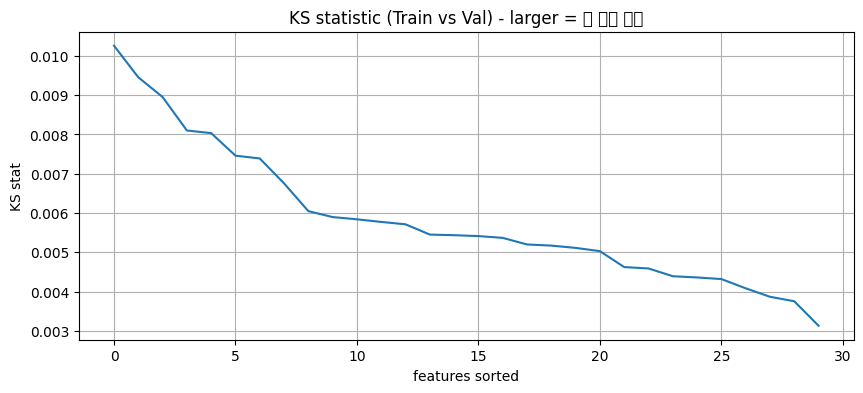

,feature,ks_stat,pvalue
29,V30,0.005314,0.055900
24,V25,0.005215,0.063787
12,V13,0.004799,0.108012
2,V3,0.004763,0.112927
7,V8,0.004540,0.146777
8,V9,0.004391,0.173727
22,V23,0.004055,0.248438
18,V19,0.003856,0.302778
13,V14,0.003698,0.351436
16,V17,0.003559,0.398394


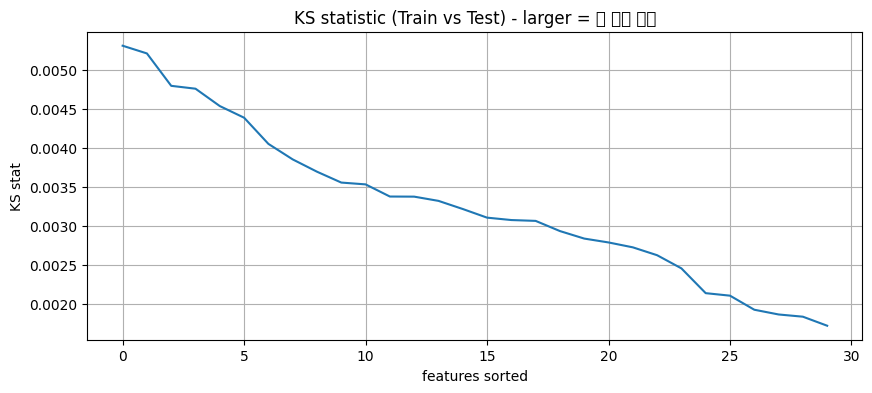

In [25]:
# ============================================================
# [추가 셀 2] 기본 sanity check + 분포 드리프트(Train vs Val/Test)
#  - 결측/중복/기초통계
#  - feature별 KS-test로 covariate shift 확인
# ============================================================
_print_header("2) Sanity check + Train/Val/Test 분포 차이(KS test)")

def basic_sanity(df, name):
    if df is None:
        return
    feat_cols = _feature_cols(df)
    print(f"\n[{name}]")
    print("- rows:", len(df))
    print("- duplicated ID:", df["ID"].duplicated().sum() if "ID" in df.columns else "N/A")
    print("- missing total:", int(df.isna().sum().sum()))
    print("- feature count:", len(feat_cols))
    if feat_cols:
        desc = df[feat_cols].describe().T
        display(desc[["mean","std","min","25%","50%","75%","max"]].head(10))

basic_sanity(train_df, "train_df")
basic_sanity(val_df, "val_df")
basic_sanity(test_df, "test_df")

# KS test: train vs val, train vs test
if train_df is not None and val_df is not None:
    feat_cols = [c for c in _feature_cols(train_df) if c in val_df.columns]
    ks_stats = []
    for c in feat_cols:
        a = train_df[c].to_numpy()
        b = val_df[c].to_numpy()
        st = ks_2samp(a, b)
        ks_stats.append((c, st.statistic, st.pvalue))
    ks_df = pd.DataFrame(ks_stats, columns=["feature","ks_stat","pvalue"]).sort_values("ks_stat", ascending=False)
    display(ks_df.head(15))

    plt.figure(figsize=(10,4))
    plt.plot(np.arange(len(ks_df)), ks_df["ks_stat"].to_numpy())
    plt.title("KS statistic (Train vs Val) - larger = 더 분포 다름")
    plt.xlabel("features sorted")
    plt.ylabel("KS stat")
    plt.show()

if train_df is not None and test_df is not None:
    feat_cols = [c for c in _feature_cols(train_df) if c in test_df.columns]
    ks_stats = []
    for c in feat_cols:
        a = train_df[c].to_numpy()
        b = test_df[c].to_numpy()
        st = ks_2samp(a, b)
        ks_stats.append((c, st.statistic, st.pvalue))
    ks_df2 = pd.DataFrame(ks_stats, columns=["feature","ks_stat","pvalue"]).sort_values("ks_stat", ascending=False)
    display(ks_df2.head(15))

    plt.figure(figsize=(10,4))
    plt.plot(np.arange(len(ks_df2)), ks_df2["ks_stat"].to_numpy())
    plt.title("KS statistic (Train vs Test) - larger = 더 분포 다름")
    plt.xlabel("features sorted")
    plt.ylabel("KS stat")
    plt.show()



3) Val 라벨 기반 변수 선택 검증 (IQR + ranksum)


,feature,iqr_hit,lo,hi,median_class1
1,V2,1,-2.699023,2.901443,3.554256
2,V3,1,-3.692900,3.834965,-5.751937
3,V4,1,-3.236039,3.118469,5.809762
9,V10,1,-2.028026,1.942435,-5.035110
8,V9,1,-2.497960,2.454348,-2.645584
6,V7,1,-2.213136,2.235690,-2.904659
13,V14,1,-1.775498,1.866871,-7.313416
11,V12,1,-1.944496,2.157787,-7.414933
10,V11,1,-3.002568,2.988136,4.512084
15,V16,1,-1.934600,1.996448,-3.412949


,feature,ranksum_p
9,V10,5.974523e-19
13,V14,7.431802e-19
10,V11,2.946090e-17
3,V4,8.616577e-17
11,V12,1.012547e-16
2,V3,1.343494e-15
8,V9,9.132573e-15
1,V2,1.695778e-14
6,V7,9.151769e-12
5,V6,4.582748e-11


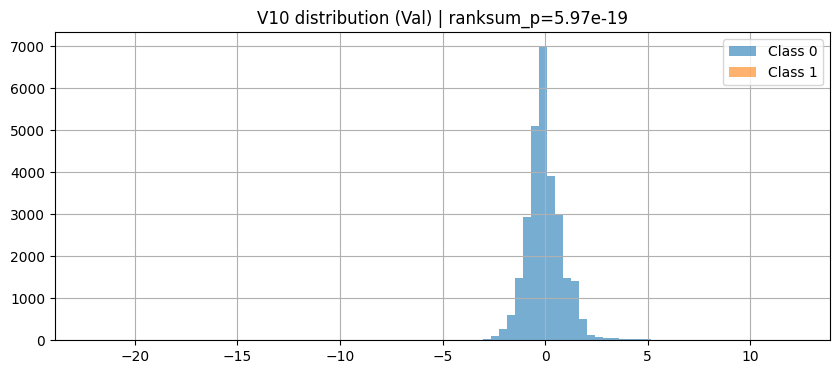

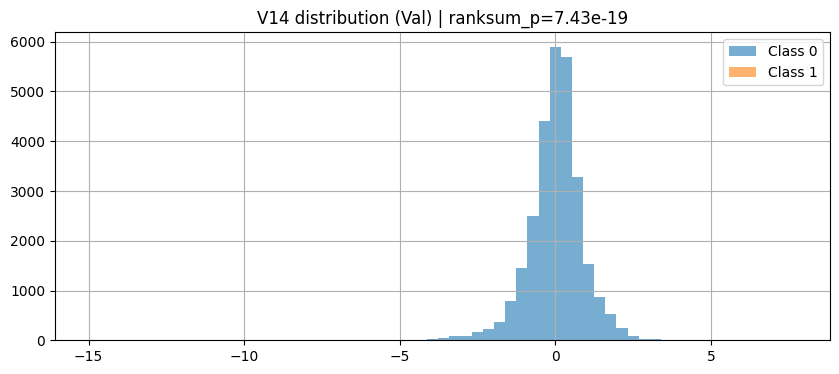

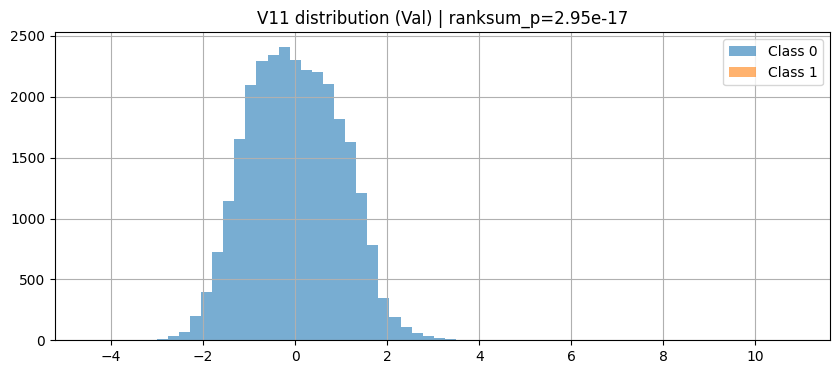

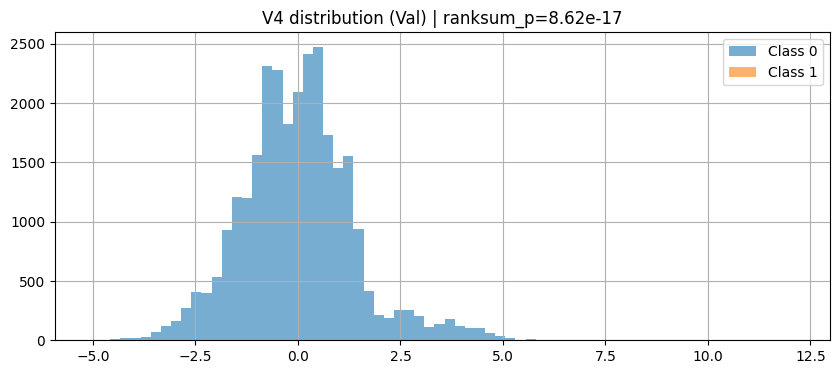

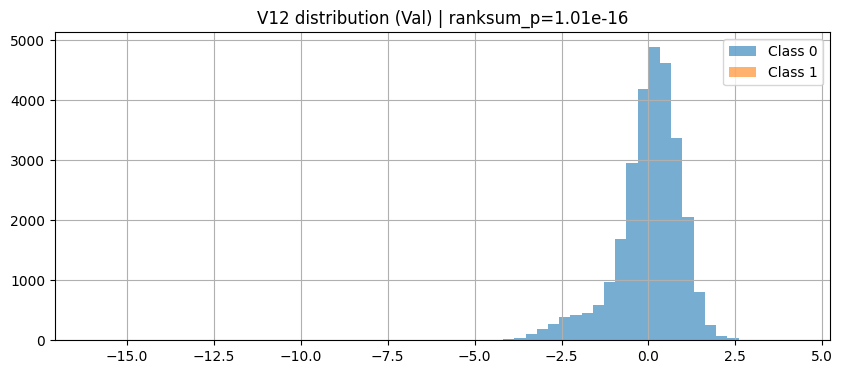

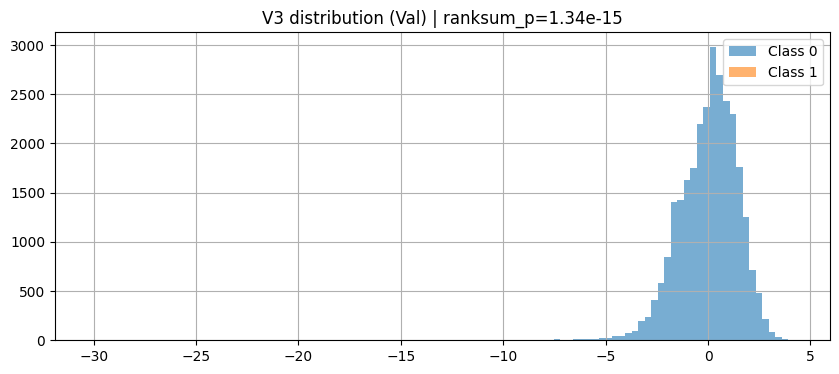

In [26]:
# ============================================================
# [추가 셀 3] (val 라벨 기반) 변수 선택이 실제로 유효했는지 시각화
#  - 1등 아이디어: IQR 범위 밖에 outlier(1) 중위값이 위치하는 변수 선택:contentReference[oaicite:11]{index=11}
#  - ranksum test 기반 유의성 확인(또는 유사 조건):contentReference[oaicite:12]{index=12}
# ============================================================
_print_header("3) Val 라벨 기반 변수 선택 검증 (IQR + ranksum)")

if ori_val_df is None or "Class" not in ori_val_df.columns:
    print("ori_val_df 또는 Class 컬럼이 없어 이 단계(라벨 기반 검증)를 스킵합니다.")
else:
    feat_cols = [c for c in _feature_cols(ori_val_df) if c in ori_val_df.columns]
    val0 = ori_val_df[ori_val_df["Class"]==0]
    val1 = ori_val_df[ori_val_df["Class"]==1]

    # IQR(정상=0 기준) 밖에 사기(1) 중위값이 위치하는지
    iqr_hits = []
    for c in feat_cols:
        q1 = val0[c].quantile(0.25)
        q3 = val0[c].quantile(0.75)
        iqr = q3 - q1
        lo = q1 - 1.5*iqr
        hi = q3 + 1.5*iqr
        med1 = val1[c].median()
        hit = int((med1 < lo) or (med1 > hi))
        iqr_hits.append((c, hit, lo, hi, med1))
    iqr_df = pd.DataFrame(iqr_hits, columns=["feature","iqr_hit","lo","hi","median_class1"])
    display(iqr_df.sort_values("iqr_hit", ascending=False).head(30))

    # ranksum p-value
    rs = []
    for c in feat_cols:
        p = ranksums(val0[c].to_numpy(), val1[c].to_numpy()).pvalue
        rs.append((c, p))
    rs_df = pd.DataFrame(rs, columns=["feature","ranksum_p"]).sort_values("ranksum_p")
    display(rs_df.head(20))

    # 시각화: iqr_hit인 변수들 중 ranksum p도 작은 상위 6개를 분포로 확인
    merged = iqr_df.merge(rs_df, on="feature")
    cand = merged[(merged["iqr_hit"]==1)].sort_values("ranksum_p").head(6)["feature"].tolist()
    if not cand:
        cand = merged.sort_values("ranksum_p").head(6)["feature"].tolist()

    for c in cand:
        plt.figure(figsize=(10,4))
        plt.hist(val0[c], bins=60, alpha=0.6, label="Class 0")
        plt.hist(val1[c], bins=60, alpha=0.6, label="Class 1")
        plt.title(f"{c} distribution (Val) | ranksum_p={merged.loc[merged.feature==c,'ranksum_p'].values[0]:.2e}")
        plt.legend()
        plt.show()



4) Stage별 임베딩/IF/voting 결과 자동 진단
[발견된 PaCMAP embedding 변수들]: ['pacmac_test1010', 'pacmac_test_1', 'pacmac_test_3', 'pacmac_train1010', 'pacmac_train_1', 'pacmac_train_3', 'pacmac_val1010', 'pacmac_val_1', 'pacmac_val_3'] 
임베딩 suffix 후보: ['1010', '_1', '_3'] 


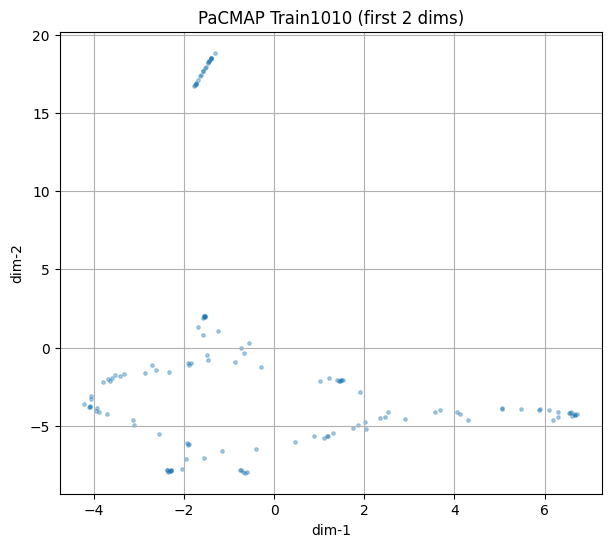

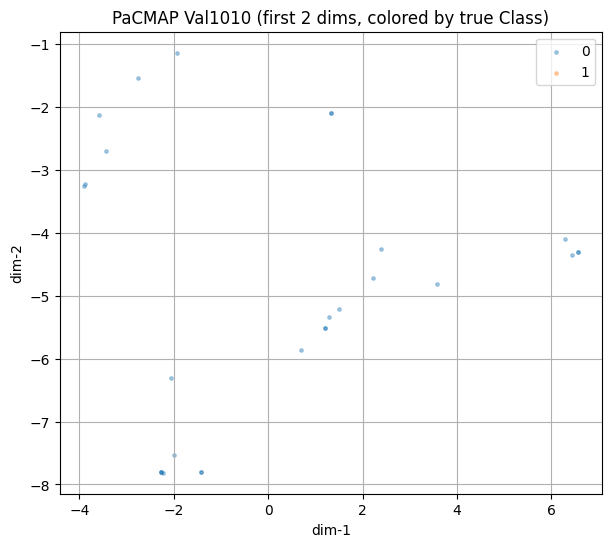

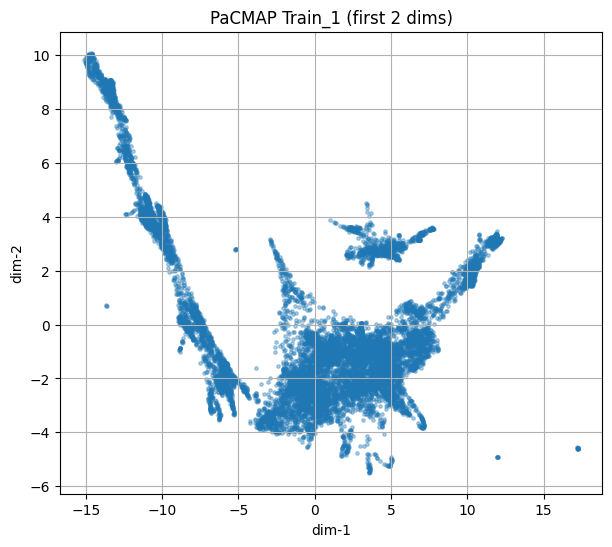

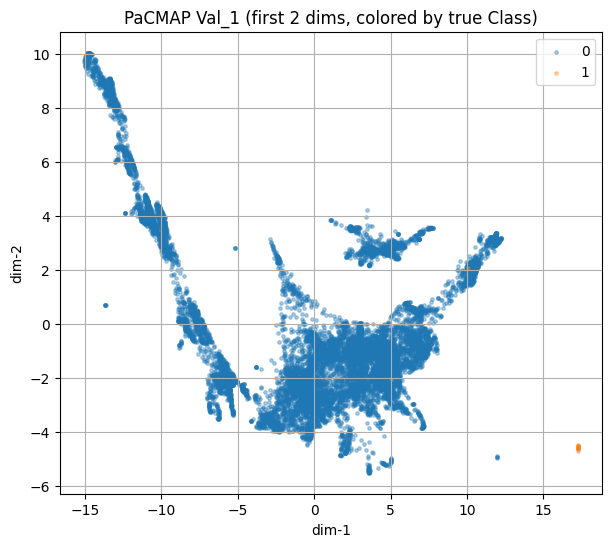

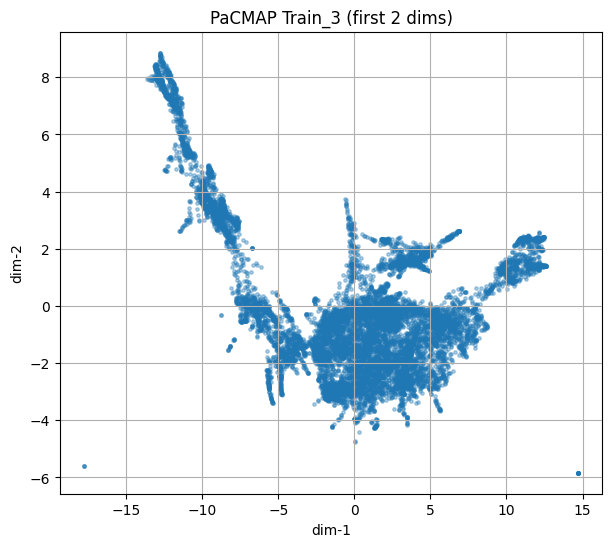

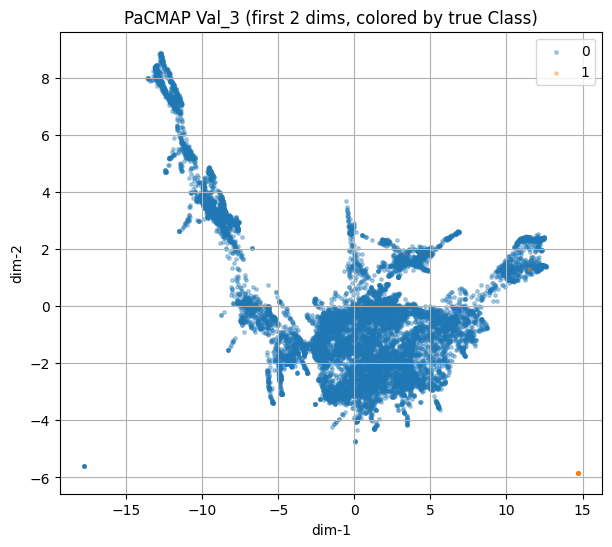


[발견된 IF 모델 후보]: ['pac_model_1', 'pac_model_3', 'summarize_iforest'] 

pac_model_1 진단에 pacmac_val_1 사용


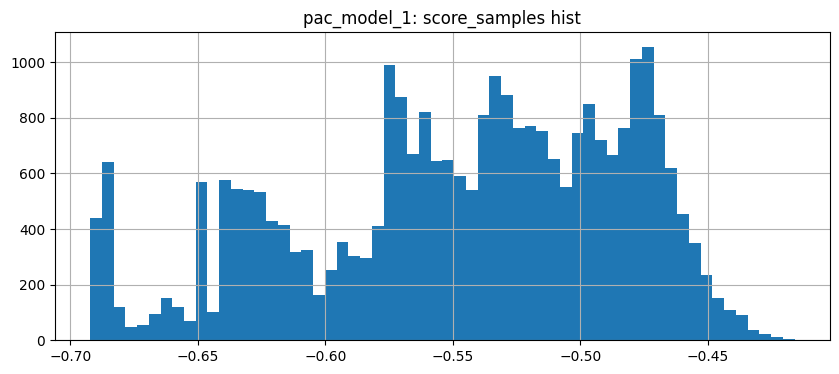

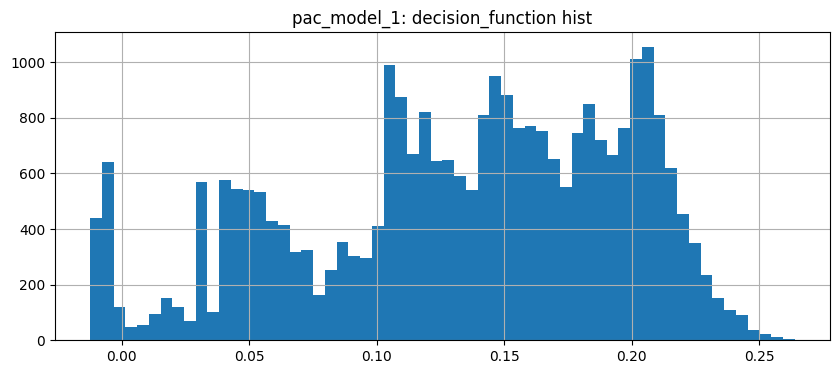

pac_model_1: ROC-AUC(val, anomaly=-decision_function) = 0.898609

[발견된 pred_set 후보]: ['test_pred_set_1', 'test_pred_set_1010', 'test_pred_set_3', 'train_pred_set_1', 'train_pred_set_1010', 'train_pred_set_3', 'val_pred_set_1', 'val_pred_set_1010', 'val_pred_set_3'] 


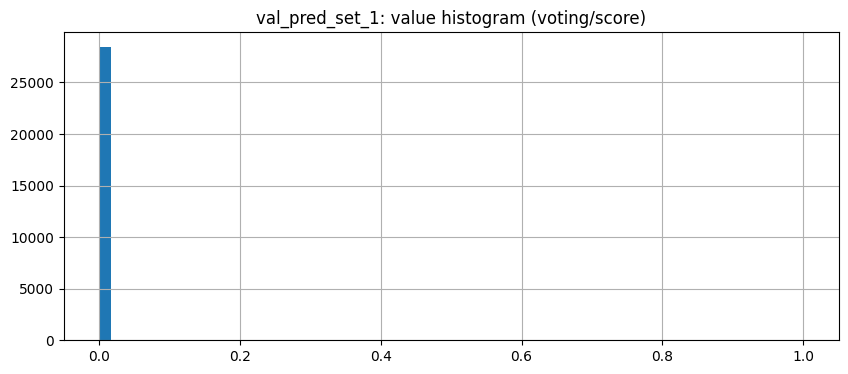

val_pred_set_1: round(.) unique counts: {0.0: 28444, 1.0: 18}
confusion_matrix (round):
 [[28414    18]
 [   30     0]]
              precision    recall  f1-score   support

           0     0.9989    0.9994    0.9992     28432
           1     0.0000    0.0000    0.0000        30

    accuracy                         0.9983     28462
   macro avg     0.4995    0.4997    0.4996     28462
weighted avg     0.9979    0.9983    0.9981     28462



In [27]:
# ============================================================
# [추가 셀 4] Stage별(PaCMAP/IF) 결과 자동 진단
#  - pacmac_train_1, pacmac_val_1 ... 같은 임베딩 변수 시각화
#  - pac_model_1 ... 같은 IF 모델이 있으면 score 분포 + val에서 성능 확인
#  - train_pred_set_1 / val_pred_set_1 ... voting 값 분포 확인
# ============================================================
_print_header("4) Stage별 임베딩/IF/voting 결과 자동 진단")

def find_by_regex(pattern):
    r = re.compile(pattern)
    return sorted([k for k in globals().keys() if r.match(k)])

# 4-1) embedding 시각화
emb_names = find_by_regex(r"pacmac_(train|val|test).*")
if emb_names:
    print("[발견된 PaCMAP embedding 변수들]:", emb_names[:20], "..." if len(emb_names)>20 else "")
else:
    print("PaCMAP embedding 변수(pacmac_*)를 못 찾았습니다. (변수명이 다를 수 있음)")

# val 라벨
val_y = None
if ori_val_df is not None and "Class" in ori_val_df.columns:
    val_y = ori_val_df["Class"].to_numpy()

# 임베딩 묶음: 같은 suffix끼리(예: _1, _2, 1010 등) 비교
def suffix_of(name):
    # pacmac_train_1 -> _1, pacmac_train1010 -> 1010
    m = re.search(r"pacmac_(?:train|val|test)(.*)$", name)
    return m.group(1) if m else ""

suffixes = sorted(set(suffix_of(n) for n in emb_names))
print("임베딩 suffix 후보:", suffixes[:20], "..." if len(suffixes)>20 else "")

for suf in suffixes[:6]:  # 너무 많으면 앞쪽 몇 개만
    tname = f"pacmac_train{suf}"
    vname = f"pacmac_val{suf}"
    if _exists(tname):
        _scatter2d(_g(tname), None, title=f"PaCMAP Train{suf} (first 2 dims)")
    if _exists(vname):
        _scatter2d(_g(vname), val_y, title=f"PaCMAP Val{suf} (first 2 dims, colored by true Class)")

# 4-2) IsolationForest score 분포 & val 성능
def summarize_iforest(model, X, y=None, name="IF"):
    X = _ensure_2d(X)
    if X is None or model is None:
        return
    # IsolationForest: score_samples 클수록 정상(일반적), decision_function도 유사(구현에 따라 스케일만 다름)
    try:
        ss = model.score_samples(X)
    except Exception:
        ss = None
    try:
        df = model.decision_function(X)
    except Exception:
        df = None
    if ss is not None:
        _hist1d(ss, title=f"{name}: score_samples hist")
    if df is not None:
        _hist1d(df, title=f"{name}: decision_function hist")

    if y is not None and df is not None:
        # “이상치일수록 작다” 가정이면 -df를 anomaly score로 사용
        try:
            auc = roc_auc_score(y, -df)
            print(f"{name}: ROC-AUC(val, anomaly=-decision_function) = {auc:.6f}")
        except Exception as e:
            print(f"{name}: AUC 계산 실패:", e)

if_names = find_by_regex(r"pac_model_.*") + find_by_regex(r".*isolation.*model.*") + find_by_regex(r".*iforest.*")
if if_names:
    print("\n[발견된 IF 모델 후보]:", if_names[:20], "..." if len(if_names)>20 else "")
else:
    print("\nIF 모델 변수(pac_model_* 등)를 못 찾았습니다. (변수명이 다를 수 있음)")

# IF가 사용하는 입력(X)도 노트북마다 다를 수 있으니:
# - 흔히 pacmac_*[:, [1,2,3]] 같은 3차원 subset을 사용함 (문서에 n_components=3 반복):contentReference[oaicite:13]{index=13}
def pick_if_X_from_embedding(emb):
    emb = _ensure_2d(emb)
    if emb is None:
        return None
    if emb.shape[1] >= 3:
        return emb[:, :3]
    return emb

# 첫 모델 하나만 대표로 진단(원하면 반복 확장 가능)
if if_names and val_y is not None:
    mname = if_names[0]
    model = _g(mname)
    # 대응되는 val 임베딩 추정: pac_model_1 -> pacmac_val_1 (완전 일치가 아닐 수 있음)
    # 최대한 "비슷한 suffix" 찾기
    suf_guess = re.sub(r"^pac_model", "", mname)
    v_candidates = [f"pacmac_val{suf_guess}", "pacmac_val_1", "pacmac_val1010"]
    Xv = None
    for vn in v_candidates:
        if _exists(vn):
            Xv = pick_if_X_from_embedding(_g(vn))
            print(f"\n{mname} 진단에 {vn} 사용")
            break
    if Xv is not None:
        summarize_iforest(model, Xv, y=val_y, name=mname)
    else:
        print(f"\n{mname}: 대응되는 val 임베딩을 못 찾아 score 진단 스킵")

# 4-3) voting 결과(예: val_pred_set_1010 등) 분포 확인:contentReference[oaicite:14]{index=14}
pred_names = find_by_regex(r"(train|val|test)_pred_set_.*") + find_by_regex(r"(train|val|test)_pred_.*set.*")
pred_names = sorted(set(pred_names))
if pred_names:
    print("\n[발견된 pred_set 후보]:", pred_names[:30], "..." if len(pred_names)>30 else "")
else:
    print("\npred_set 계열 변수를 못 찾았습니다.")

def summarize_predset(name, y_true=None):
    a = _g(name)
    if a is None:
        return
    a = np.asarray(a)
    if a.ndim > 1:
        # DataFrame이면 Class 컬럼 우선
        if hasattr(a, "shape") and isinstance(_g(name), pd.DataFrame):
            df = _g(name)
            if "Class" in df.columns:
                a = df["Class"].to_numpy()
            else:
                a = df.iloc[:,0].to_numpy()
        else:
            a = a.reshape(-1)

    _hist1d(a, title=f"{name}: value histogram (voting/score)")
    # round 결과 카운트
    rr = np.round(a)
    u, c = np.unique(rr, return_counts=True)
    print(f"{name}: round(.) unique counts:", dict(zip(u.tolist(), c.tolist())))

    if y_true is not None and "val" in name:
        try:
            print("confusion_matrix (round):\n", confusion_matrix(y_true, rr.astype(int)))
            print(classification_report(y_true, rr.astype(int), digits=4))
        except Exception as e:
            print("val 성능 출력 실패:", e)

for n in pred_names:
    if n.startswith("val_") or "val" in n:
        summarize_predset(n, y_true=val_y)
        break  # 너무 많이 찍히면 지저분하니 대표 1개만



5) KernelPCA 단계(가짜 outlier 분리) 시각화/검증
one_train_df: (131, 30)  one_val_df: (28, 31)  one_test_df: (306, 30)
one_val_df Class counts: {1: 25, 0: 3}
X_transformed shape: (131, 5)


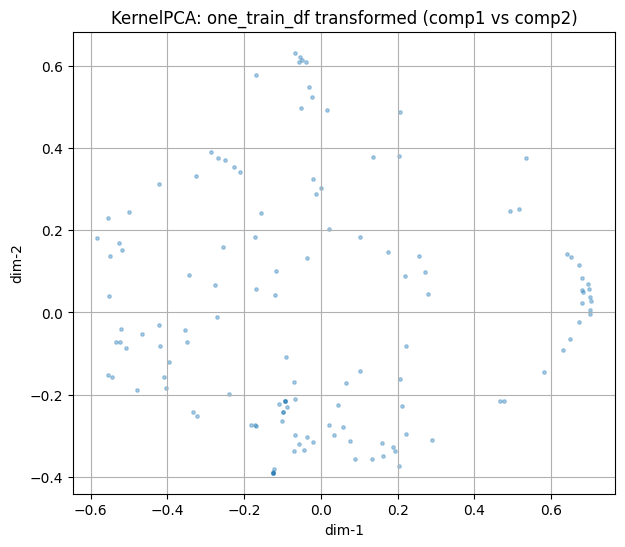

X1_transformed shape: (28, 5)


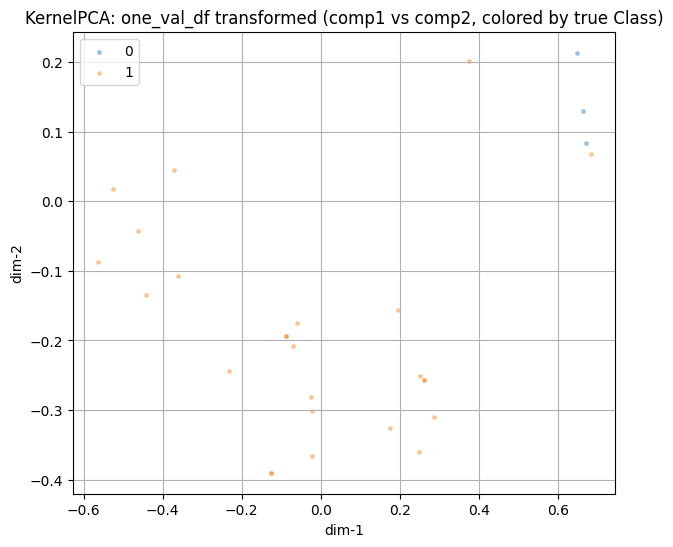

pca_train_wow: (131, 3) pca_val_wow: (28, 3)


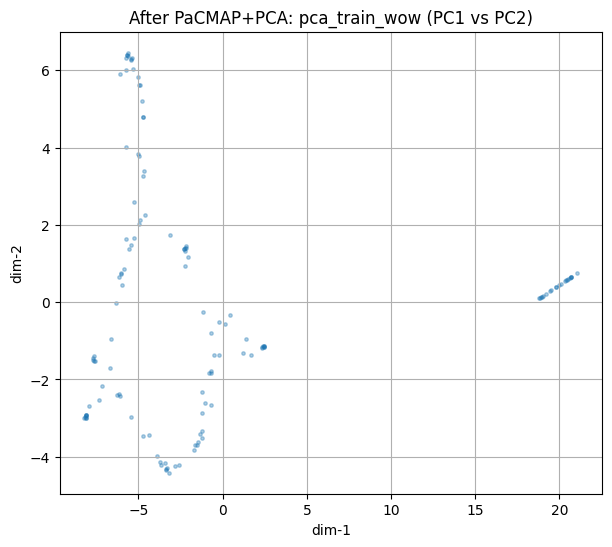

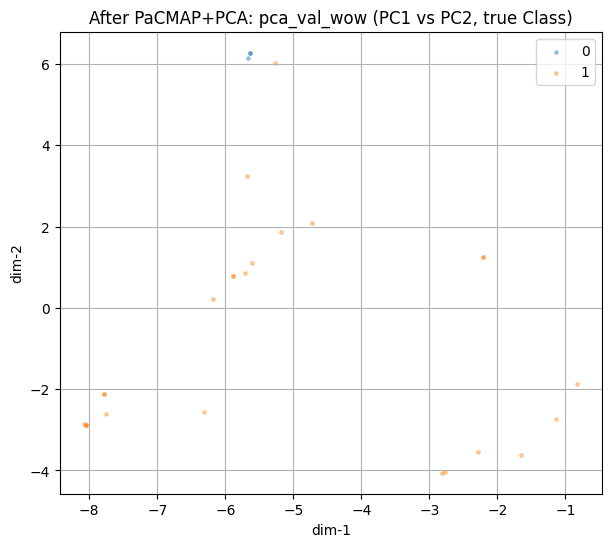

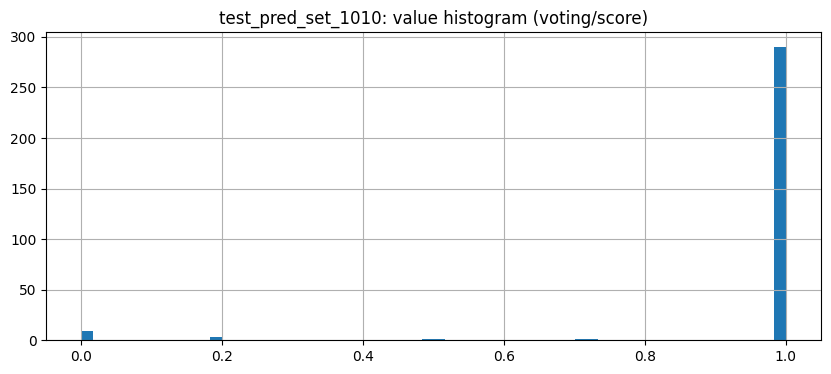

test_pred_set_1010: round(.) unique counts: {0.0: 13, 1.0: 293}


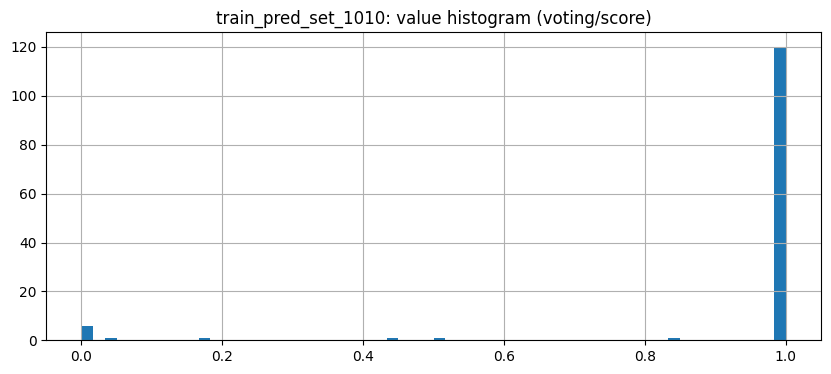

train_pred_set_1010: round(.) unique counts: {0.0: 9, 1.0: 122}


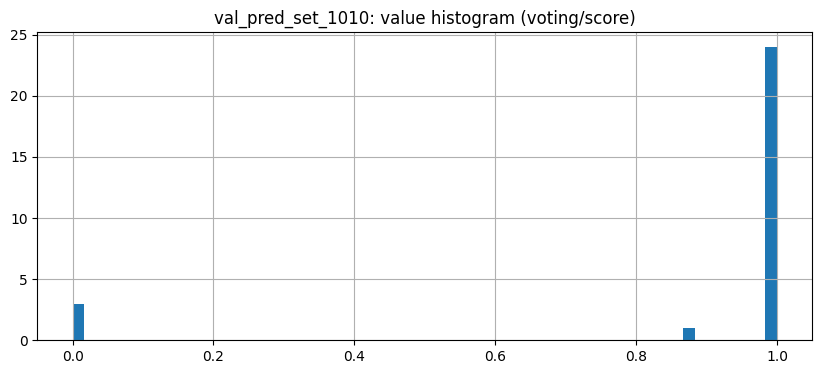

val_pred_set_1010: round(.) unique counts: {0.0: 3, 1.0: 25}
confusion_matrix (round):
 [[ 3  0]
 [ 0 25]]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         3
           1     1.0000    1.0000    1.0000        25

    accuracy                         1.0000        28
   macro avg     1.0000    1.0000    1.0000        28
weighted avg     1.0000    1.0000    1.0000        28



In [28]:
# ============================================================
# [추가 셀 5] KernelPCA 기반 "outlier 중 fake outlier(0)" 제거 단계 시각화
#  - 문서 흐름: one_* (round(pred_set_3)==1) -> ranksum으로 변수 선택
#             -> KernelPCA(n_components=5, rbf) -> PaCMAP -> PCA -> 극단값으로 판별:contentReference[oaicite:15]{index=15}:contentReference[oaicite:16]{index=16}
# ============================================================
_print_header("5) KernelPCA 단계(가짜 outlier 분리) 시각화/검증")

# 5-1) one_train_df / one_val_df 존재하면 기본 확인
one_train_df = _g("one_train_df")
one_val_df   = _g("one_val_df")
one_test_df  = _g("one_test_df")

if one_train_df is None or one_val_df is None:
    print("one_train_df/one_val_df를 못 찾았습니다. (KernelPCA 단계까지 실행 안 했을 수 있음)")
else:
    print("one_train_df:", one_train_df.shape, " one_val_df:", one_val_df.shape, " one_test_df:", None if one_test_df is None else one_test_df.shape)
    if "Class" in one_val_df.columns:
        print("one_val_df Class counts:", one_val_df["Class"].value_counts().to_dict())

# 5-2) KernelPCA 변환 결과(X_transformed, X1_transformed 등) 있으면 2D 투영
X_transformed  = _g("X_transformed")
X1_transformed = _g("X1_transformed")
X2_transformed = _g("X2_transformed")

if X_transformed is not None:
    Xt = _ensure_2d(X_transformed)
    # KPCA는 5차원으로 하는 경우가 문서에 있음:contentReference[oaicite:17]{index=17}
    print("X_transformed shape:", Xt.shape)
    _scatter2d(Xt[:, :2], None, title="KernelPCA: one_train_df transformed (comp1 vs comp2)")
else:
    print("X_transformed를 못 찾았습니다. (KernelPCA 변환 변수가 다른 이름일 수 있음)")

if X1_transformed is not None and one_val_df is not None and "Class" in one_val_df.columns:
    Xv = _ensure_2d(X1_transformed)
    yv = one_val_df["Class"].to_numpy()
    print("X1_transformed shape:", Xv.shape)
    _scatter2d(Xv[:, :2], yv, title="KernelPCA: one_val_df transformed (comp1 vs comp2, colored by true Class)")

# 5-3) kernel pca 이후 pacmap1010 + pca_train_wow/pca_val_wow가 있으면 극단값 분리 시각화
pca_train_wow = _g("pca_train_wow")
pca_val_wow   = _g("pca_val_wow")
if isinstance(pca_train_wow, pd.DataFrame) and isinstance(pca_val_wow, pd.DataFrame):
    print("pca_train_wow:", pca_train_wow.shape, "pca_val_wow:", pca_val_wow.shape)
    yv = None
    if one_val_df is not None and "Class" in one_val_df.columns:
        yv = one_val_df["Class"].to_numpy()

    _scatter2d(pca_train_wow.iloc[:, :2].to_numpy(), None, title="After PaCMAP+PCA: pca_train_wow (PC1 vs PC2)")
    if yv is not None:
        _scatter2d(pca_val_wow.iloc[:, :2].to_numpy(), yv, title="After PaCMAP+PCA: pca_val_wow (PC1 vs PC2, true Class)")
else:
    print("pca_train_wow / pca_val_wow를 못 찾았습니다. (KernelPCA loop 내부 변수라 실행 위치에 따라 남지 않을 수 있음)")

# 5-4) 최종 fake-outlier 판별 결과(train_pred_set_1010 등)가 있으면 분포/비율 확인:contentReference[oaicite:18]{index=18}
fake_names = find_by_regex(r"(train|val|test)_pred_set_1010")
if fake_names:
    for n in fake_names:
        summarize_predset(n, y_true=None if "val" not in n else (one_val_df["Class"].to_numpy() if one_val_df is not None and "Class" in one_val_df.columns else None))
else:
    print("train/val/test_pred_set_1010을 못 찾았습니다. (최종 fake-outlier 판별까지 실행 안 했을 수 있음)")



6) 최종 round/voting 결과 점검
선택된 최종 후보: val_pred_set_3


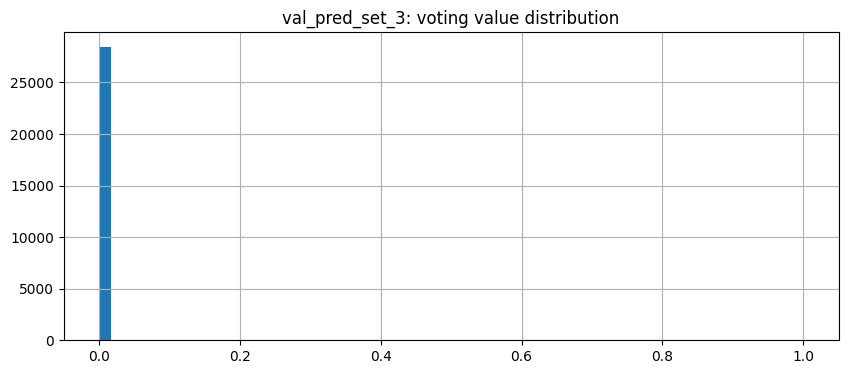

round 결과 분포: {0: 28434, 1: 28}

confusion_matrix:
 [[28429     3]
 [    5    25]]
              precision    recall  f1-score   support

           0     0.9998    0.9999    0.9999     28432
           1     0.8929    0.8333    0.8621        30

    accuracy                         0.9997     28462
   macro avg     0.9463    0.9166    0.9310     28462
weighted avg     0.9997    0.9997    0.9997     28462



In [29]:
# ============================================================
# [추가 셀 6] 최종 제출 직전 체크(라운딩/투표/개수)
#  - 문서: "voting해서 50% 이상 1이면 1":contentReference[oaicite:19]{index=19}
# ============================================================
_print_header("6) 최종 round/voting 결과 점검")

# 가장 마지막 단계로 보이는 pred_set 후보를 val 기준으로 하나 골라 점검
val_pred_candidates = [k for k in globals().keys() if re.match(r"val_pred_set_.*", k)]
val_pred_candidates = sorted(val_pred_candidates)

if not val_pred_candidates:
    print("val_pred_set_* 변수를 못 찾았습니다.")
else:
    last = val_pred_candidates[-1]
    print("선택된 최종 후보:", last)
    a = _g(last)
    if isinstance(a, pd.DataFrame):
        a = a["Class"].to_numpy() if "Class" in a.columns else a.iloc[:,0].to_numpy()
    a = _ensure_1d(a)

    _hist1d(a, title=f"{last}: voting value distribution")
    rr = np.round(a).astype(int)
    u, c = np.unique(rr, return_counts=True)
    print("round 결과 분포:", dict(zip(u.tolist(), c.tolist())))

    if ori_val_df is not None and "Class" in ori_val_df.columns:
        y = ori_val_df["Class"].to_numpy()
        print("\nconfusion_matrix:\n", confusion_matrix(y, rr))
        print(classification_report(y, rr, digits=4))
